4. SMS/Email Spam Detection
   - Goal: Classify messages as spam or not spam.
   - Dataset: SMS Spam Dataset (UCI or Kaggle).
   - Tools: Naive Bayes, TF-IDF, NLP preprocessing.
   - Skills: Text classification, Natural Language Processing.

In [1]:
# Importing required librararies

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text Preprocessing
import nltk
import re
import string

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [2]:
# Load Dataset
 
df = pd.read_csv('spam.csv',encoding='latin-1')
df.head()


# Cleaning Dataset

# Keeping only the columns we need

# df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)             #alternative

# OR

df = df[['v1', 'v2']]


# Rename them for clarity

df.columns = ['label', 'message']


# Show updated dataframe

df.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# checking dataset info

df.info()
df.describe()
df['label'].value_counts()          # No missing values expected



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


label
ham     4825
spam     747
Name: count, dtype: int64

Encode the Labels (Spam = 1, Ham = 0)

    bcz Most ML models in scikit-learn expect numerical targets.
    
    This is a binary classification problem, so:
                                                    0 = Not Spam (Ham)
                                                    1 = Spam

In [4]:
# Convert 'spam' to 1 and 'ham' to 0
df['label'] = df['label'].map({'ham': 0, 'spam': 1})


# Check the result
df.head()


# Check how many ham and spam
df['label'].value_counts()


label
0    4825
1     747
Name: count, dtype: int64

Text Cleaning & NLP Preprocessing

    Preparing it for ML by doing
        
        Lowercasing all text

        Removing punctuation, numbers, and special characters

        Removing stopwords (like "the", "is", "in")

        Tokenizing (splitting sentences into words)

        Stemming (reducing words to their root form)

In [9]:
# setup NLP tools only once

import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pushk\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pushk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pushk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    # Lowercase
    text = text.lower()
    
    # Remove non-alphabet characters (punctuation, numbers, etc.)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # Tokenize (split into words)
    words = nltk.word_tokenize(text)
    
    # Remove stopwords and punctuation, apply stemming
    clean_words = [stemmer.stem(word) for word in words if word not in stop_words and word not in string.punctuation]
    
    return ' '.join(clean_words)

# Apply preprocessing to the messages
df['cleaned_message'] = df['message'].apply(preprocess)
df

,label,message,cleaned_message
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...
3,0,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though
...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,nd time tri contact u u pound prize claim easi...
5568,0,Will Ì_ b going to esplanade fr home?,b go esplanad fr home
5569,0,"Pity, * was in mood for that. So...any other s...",piti mood suggest
5570,0,The guy did some bitching but I acted like i'd...,guy bitch act like interest buy someth els nex...


Convert Text into Numbers using TF-IDF

    Convert each cleaned message (text) into a numeric vector using TF-IDF (Term Frequency – Inverse Document Frequency).

Why TF-IDF?
    It converts words → numbers, but in a smart way.

    Gives higher weight to important words (like “free”, “win”) and less weight to common words (like “the”, “is”).

    Creates a sparse matrix where each row = message and each column = word/feature.

In [15]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=3000)  # can adjust the feature size if needed

# Fit and transform the cleaned messages
X = vectorizer.fit_transform(df['cleaned_message']).toarray()

# Target variable
y = df['label'].values

# Check shapes
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (5572, 3000)
Shape of y: (5572,)


Train-Test Split

    Spliting dataset into:

        Training set (used to train the model)

        Test set (used to evaluate how well the model performs on unseen data)

In [17]:
from sklearn.model_selection import train_test_split

# Split the data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Confirm the shapes
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (4457, 3000)
Testing data shape: (1115, 3000)


Training Model with Naive bayes

    (great algorithm for text classification, especially when features are word counts or frequencies)
    It calculates the probability of a message being spam or not spam based on the words it contains.

In [ ]:
# Initialize the model
model = MultinomialNB()

# Train (fit) the model
model.fit(X_train, y_train)

# NOw model is trained..
# If a message contains words like “free”, “win”, “urgent”, the probability of spam increases

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


Model Evaluation

    Accuracy

    Confusion Matrix

    Precision, Recall, F1-score

Accuracy: 0.9757847533632287

Classification Report:

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       1.00      0.82      0.90       150

    accuracy                           0.98      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0.98      0.98      0.97      1115



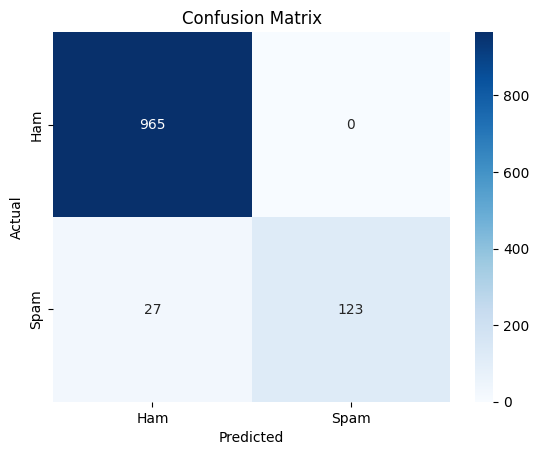

In [ ]:
# Make predictions on test set
y_pred = model.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix (visual)
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Predict on New (Custom) Messages

In [20]:
# Sample test messages
sample_messages = [
    "Congratulations! You’ve won a $1000 Walmart gift card. Click here to claim now.",
    "Are we still meeting at 6 today?",
    "URGENT! Your account has been suspended. Login immediately to resolve.",
    "Hey, can you call me back when you're free?",
    "Free entry in 2 a weekly competition to win FA Cup final tickets. Text WIN to 87066 now!"
]

# Preprocess each message
sample_cleaned = [preprocess(msg) for msg in sample_messages]

# Convert to TF-IDF vectors
sample_vector = vectorizer.transform(sample_cleaned)

# Predict
predictions = model.predict(sample_vector)

# Show results
for msg, label in zip(sample_messages, predictions):
    print(f"\nMessage: {msg}")
    print("Prediction:", "Spam" if label == 1 else "Ham")



Message: Congratulations! You’ve won a $1000 Walmart gift card. Click here to claim now.
Prediction: Spam

Message: Are we still meeting at 6 today?
Prediction: Ham

Message: URGENT! Your account has been suspended. Login immediately to resolve.
Prediction: Spam

Message: Hey, can you call me back when you're free?
Prediction: Ham

Message: Free entry in 2 a weekly competition to win FA Cup final tickets. Text WIN to 87066 now!
Prediction: Spam


What I learned

    Dataset Handling: loaded and cleaned message data using pandas.

    Label Encoding: Converted "spam" and "ham" labels into numbers (1s and 0s).

    NLP Preprocessing: Cleaned text by lowercasing, removing special characters, tokenizing, removing stopwords, and stemming words.

    Feature Extraction: Transformed text into numerical features using TF-IDF.

    Model Building: Built a spam classifier using Multinomial Naive Bayes.

    Evaluation: Measured the model's performance using accuracy, confusion matrix, and a classification report.

    Real-world Prediction: Tested the classifier with new, custom messages...